## Final Project Submission

Please fill out:
* Student name: **Raymond Willey**
* Student pace: **Self Paced**
* Scheduled project review date/time: **August 1, 2019 7:00pm EST**
* Instructor name: **Eli Thomas**
* Non-Technical Presentation: **[Information Overload](https://www.overloadblog.info/blog/building-a-deep-neural-network-to-analyze-presidential-speeches)**
* Blog post URL: **[Toward Data Science](https://medium.com/p/using-artificial-neural-networks-to-analyze-presidential-speeches-6fbd446c5bad?source=email-75f6c61ec59a--writer.postDistributed&sk=6ad3a4122b1ea2a1e4ce05fc0b6c73a6)**

## Identifying the Optimal Hyperparameters for a Neural Network
Though the grid search used to accomplish this task for identifying quotes from Donald Trump and Hillary Clinton, it is also clear that performance in this regard is ubiquitous to all sets of presidents. When comparing Washington to Lincoln, and Reagan to Obama, the predictive power of the models was notably weaker. Furthermore, it is inefficient to search through 88 different models each time we want to compare two presidents.

The objective of this notebook is to demonstrate a method for identifying optimal hyperparameters that will be more generalizable to the overall dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, string, re
import datetime
import warnings
import tensorflow.python.util.deprecation as deprecation

deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings('ignore')

## Exploratory Analysis & Data Imbalance
In the case of Clinton and Trump, as well as Washington and Lincoln, it was observed that Trump and Lincoln had significantly more content to draw from. Such imbalance would allow a network to simply guess the more prominent speaker more frequently to improve its accuracy score. One of the first things to do is to get a sense of the degree of imbalance across the dataset.

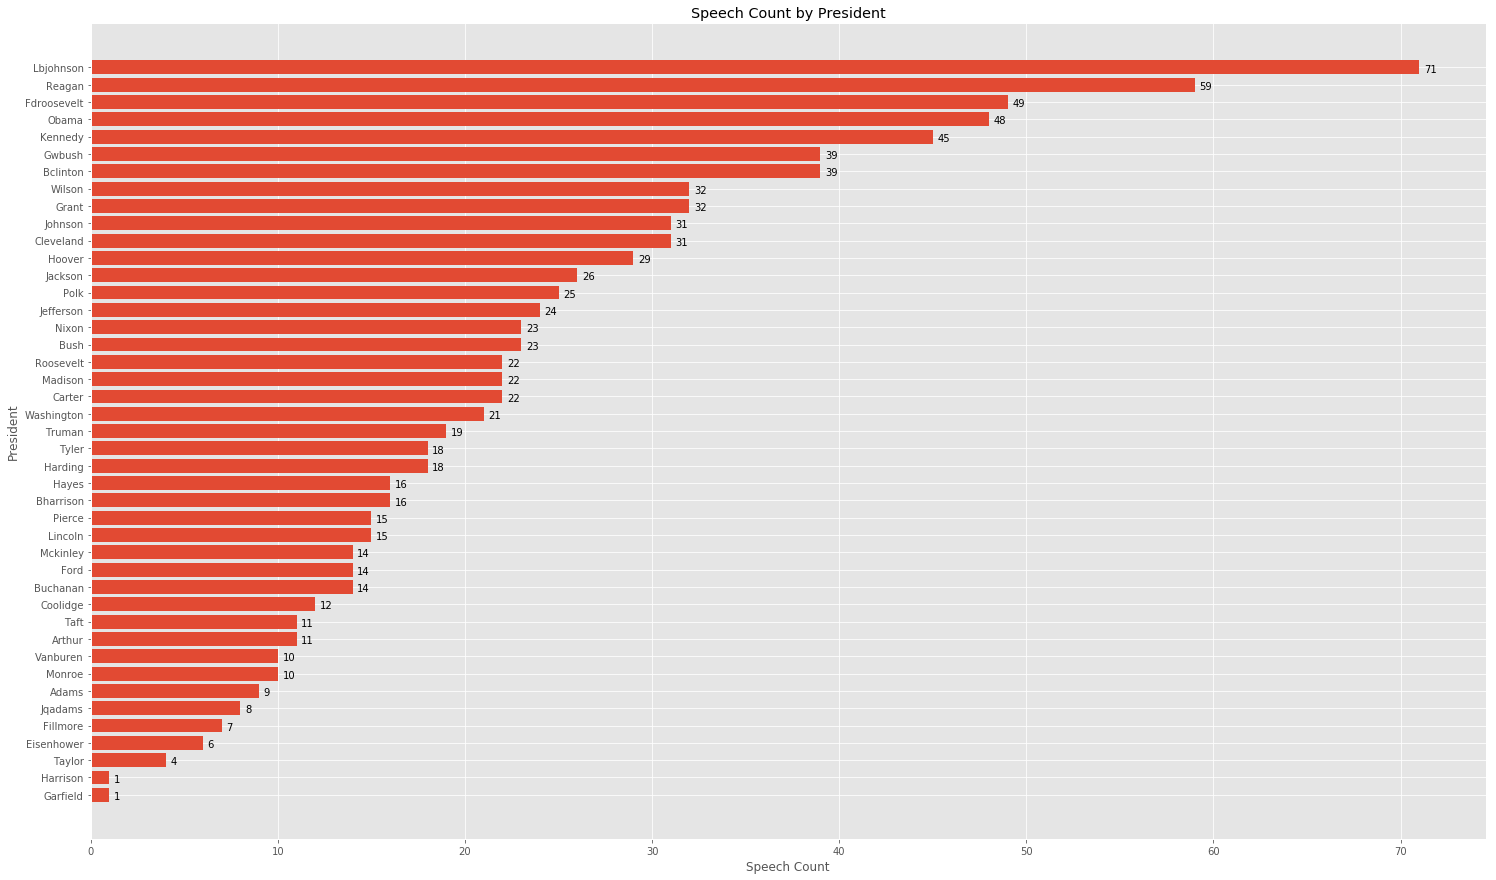

In [50]:
import operator

lvl1 = 'Corpus of Presidential Speeches/'

# Create dictionary to count number of speeches. 
speech_dict = {}

# For each folder, save the folder name & file count to the dictionary
i=0
for folder in sorted(os.listdir(lvl1)):
    if folder not in ['.DS_Store', 'trump', 'hclinton']:
        speech_dict[folder.title()] = 0
        for file in os.listdir(lvl1 + folder):
            speech_dict[folder.title()] += 1

# Sort results by speech count
sorted_speech_dict = sorted(speech_dict.items(), key=operator.itemgetter(1))

# Plot the results
plt.style.use('ggplot')

x = [val[1] for val in sorted_speech_dict]
y = range(len(sorted_speech_dict))
plt.figure(figsize=(25, 15))
plt.barh(y, x)
plt.yticks(range(len(sorted_speech_dict)), [val[0] for val in sorted_speech_dict])
plt.yticks()
for i, v in enumerate(x):
    plt.text(v + .25, i-.25, str(v))
plt.title('Speech Count by President')
plt.xlabel('Speech Count')
plt.ylabel('President')
plt.show()

As we can see from the above chart, the top 10 most vocal presidents account for nearly 50% of the speeches. The initial goal of the project was to be able to identify passages by any given president, but this imbalance created a large problem: the network was able to optimize accuracy by limiting its predictions to these 10 individuals. Attempts to balance the dataset would lead to problems in the other direction.

James Garfield and William Harrison both died early in their presidencies: Garfield was assassinated after 100 days in office, while Harrison died after just 30 days as a result of a sickness he afflicted during his inaugural address in frigid temperatures. To reduce the corpora of all presidents to match the lowest common denominator would be to eliminate nearly 99% of the data. Furthermore, unless Garfield and Harrison frequently repeated themselves during their respective speeches, then all predictions related to them should be regarded as little more than random chance.

**At what point do we set a cutoff? What is the minimum speech corpora required to make meaningfully accurate predictions?**

The strategy here will be to select president pairs at random, and perform the same process as with Trump and Hillary, saving the numerical results to a dataframe. Sample size and hyperparameters will be tracked with this. 

One key difference, however, is that instead of searching for the optimal network each time, a random set of hyperparameters for one CNN and one RNN network will be chosen, and the result stored. The aim here is not to maximize accuracy, but to gather data which will allow for an analysis of which features and parameters produce the best overall results.

## Process Setup
The general process for generating data is as follows:

1. Select 2 Presidents at Random & Get Data
2. Preprocessing & Balancing Dataset
3. Benchmarking
4. Model Generation
5. Train & Test
6. Save Results

Code for steps 1 - 5 has already been created in part 1 of this project, and each portion of that code has been turned into a function here.

### 1. Select Random Presidents
Note that campaign speeches from Trump and Clinton will be omitted from this analyis. The reason for this is that how a candidate speaks on the campaign trail may be vastly different than when in office. While campaigning, efforts are made to differentiate, but once in office, the objective is to unify. Given the volume of data, and the relative ease with which such speeches may be differentiated from any other president, it could end up biasing the results.

In [3]:
import random

def get_presidents():
    i=1
    selection_index = {}
    for pres in sorted(list(os.listdir('Corpus of Presidential Speeches/')))[1:]:
        
        if (pres == 'trump') or (pres == 'hclinton'):
            pass
        else:
            selection_index[i] = pres
            i += 1

    selections = random.sample(range(1, 44), 2)

    return sorted([selection_index[selections[0]], 
                   selection_index[selections[1]]], reverse=True)

In [4]:
def get_texts():
    selections = get_presidents()
    p1, p2 = sorted([selections[0], selections[1]])
    lvl1 = 'Corpus of Presidential Speeches/'

    speech_dict = {'president': [], 'name': [], 'text': []}
    labels_index = {}
    speech_count = {}

    i=0
    for folder in sorted(os.listdir(lvl1)):
        if folder in selections:
            labels_index[i] = folder.lower()
            speech_count[folder] = [0]

            for file in os.listdir(lvl1 + folder):
                speech_count[folder][0] += 1

                with open(f'{lvl1}{folder}/{file}', 'r') as f:
                    data = f.read()

                    # Remove tags for date, title, etc. and line breaks
                    no_tags = re.sub('<[^>]+>', '', data)
                    no_line_breaks = no_tags.replace('\n', ' ')
                    no_ellipses = no_line_breaks.replace('...', ' ')
                    no_dashes = no_ellipses.replace('-', ' ')

                    # Split data into sentences
                    sentences = no_dashes.split('. ')

                    # Every ~50 words treated as paragraph
                    while len(sentences) > 0:
                        text = []
                        while (len(text) < 50) and (len(sentences) > 0):
                            sentence = sentences.pop(0)
                            if (len(sentence) > 0) and (sentence[-1] not in ['?', '!']):
                                sentence = sentence + '.'
                            text += sentence.split()

                        speech_dict['text'].append(' '.join(text))
                        speech_dict['president'].append(i)
                        speech_dict['name'].append(folder.title())
                    f.close()

            i+=1

    df = pd.DataFrame.from_dict(speech_dict)
    df['length'] = df['text'].apply(lambda x: len(x.split()))
    df = df[df['length'] >= 50]
    num_classes = len(df['president'].unique())
    return df, p1, p2, num_classes

### 2. Preprocessing
#### Expand Contractions

In [5]:
from contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

#### Remove Special Characters

In [6]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

#### Lemmatize Text
Get the root word of text using Spacy

In [7]:
import spacy
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

#### Remove Stopwords & Tokenize
The words *no* and *not* can inherently change the meaning of leading and following words, so these should be removed from the stopwords list. In order to remove the stopwords, samples must first be tokenized.

In [8]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# Add characters not captured in special character removal to stop list
stopword_list += ['[', ']', "\\"]   

def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens) 
    
    return filtered_text

#### Clean Text
The following code combines the above functions into a series of steps which will clean all samples and tokenize them for analysis.

In [9]:
import unicodedata

def clean_text(df):
    
    clean_text = []
    for text in df['text']:
        no_accent_chars = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        expanded_text = expand_contractions(no_accent_chars)
        no_special_chars = remove_special_characters(expanded_text, remove_digits=False)
        lem_text = lemmatize_text(no_special_chars)
        filtered_text = remove_stopwords(lem_text)
        
        lowercase_text = filtered_text.lower()
        words = lowercase_text.split()
        clean_text.append(words)

    df['clean_text'] = clean_text
    return df

#### Balance Dataset
Check the sample size for each president and reduce the larger one to match the other.

In [10]:
def balance_datasets(df):
    # Shuffle the Dataset.
    shuffled_df = df.sample(frac=1)

    # Create dictionary to store scaled dataframes for each president.
    scaled_dfs = {}

    # Set max samples based on president with fewest paragraphs
    n = shuffled_df.loc[shuffled_df['name'] == df['name'].value_counts().index[-1]].shape[0]

    #Randomly select n observations from the non-fraud (majority class)
    for name in df['name'].unique():
        scaled_dfs[f'{name}_df'] = shuffled_df.loc[shuffled_df['name'] == name].sample(n=n)

    # Concatenate dataframes
    scaled_dfs = [scaled_dfs[key] for key in list(scaled_dfs.keys())]
    normalized_df = pd.concat(scaled_dfs)
    
    return normalized_df

#### Get Bigrams
Search for common 2-word phrases that can be converted to bigrams (i.e. "United States", "Nuclear Weapon", etc.)

In [11]:
from gensim.models import phrases

def get_bigrams(normalized_df):
    target = normalized_df.president
    data = normalized_df['clean_text'].values

    bigrams = phrases.Phrases(data)
    bigrams_data = []

    for i in range(len(data)):
        bigrams_data.append(bigrams[data[i]])

    bigrams_data = np.array(bigrams_data)

    max_len = 0
    for bigram in bigrams_data:
        max_len = len(bigram) if len(bigram) > max_len else max_len

    return target, data, bigrams_data, max_len

#### Vectorization
Convert words to vectors using GloVe

In [12]:
def make_embedding_index(total_vocabulary):
    embeddings_index = {}
    f = open('glove.6B.100d.txt', encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        if word in total_vocabulary:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [13]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_index))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

### Benchmarking
Build Random Forest, Support Vector Machine, and Logistic Regression classifiers to analyze the data, using the top performing model as a benchmark.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from operator import itemgetter

def get_benchmark(embeddings_index):
    rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                    ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=False, n_jobs=-1))])
    svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                    ('Support Vector Machine', SVC())])
    lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(embeddings_index)),
                    ('Logistic Regression', LogisticRegression(n_jobs=-1))])
    
    models = [('Random Forest', rf),
              ("Support Vector Machine", svc),
              ("Logistic Regression", lr)]
    
    scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model in models]
    return max(scores,key=itemgetter(1))

### Model Generation

In [15]:
from keras import backend as K 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Conv1D, MaxPooling1D, Flatten
from keras.models import Model, Sequential, load_model
from keras.metrics import categorical_crossentropy
from keras.preprocessing import text
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


#### Sequencing
Data must be retokenized and sequenced here with padding to properly create an embedding matrix for the neural networks. Function returns sequenced data, the target variable as dummies, and the total unique word index.

In [16]:
def get_X_y(target, bigrams_data, max_len, normalized_df):
    y = pd.get_dummies(target).values
    
    bigrams_joined = []

    for bigrams in bigrams_data:
        bigrams_joined.append(' '.join(bigrams))

    # Remove underscore from filters and no need to convert to lowercase
    tokenizer = text.Tokenizer(filters='!"#%&()*+,./:;<=>?@[\\]^`{|}~\t\n', lower=False)
    tokenizer.fit_on_texts(bigrams_joined)
    sequences = tokenizer.texts_to_sequences(bigrams_joined)

    word_index = tokenizer.word_index
    
    X_t = pad_sequences(sequences, maxlen=max_len, padding='post')
    X_t_df = pd.DataFrame(X_t)
    X_t_df['bigrams'] = bigrams_data
    X_t_df['text'] = normalized_df.reset_index(drop=True)['text']
    return X_t_df, y, word_index

#### Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

def tt_split(X_t_df, y):
    X_train, X_test, y_train, y_test = train_test_split(X_t_df, y, test_size=.5)

    X_train_text = X_train[['text', 'bigrams']]
    X_train = X_train[X_train.columns[:-2]]

    X_test_text = X_test[['text', 'bigrams']]
    X_test = X_test[X_test.columns[:-2]]
    return X_train, X_train_text, X_test, X_test_text, y_train, y_test

#### Vectorize
As with benchmark, all terms to be vectorized using GloVe.  

In [18]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

#### Create Embedding Layer for Neural Network
For each word in each sample, a vector will be assigned from the embedding index. If the word is not found, it will be assigned a random vector.

*Note: Because word connotations and meanings change over time, and because GloVe is based on modern Wikipedia content, it would be unwise to freeze these vectors. Words used 50+ years ago may not have the same dimensional meaning, so the networks should be free to make the appropriate adjustments.*

In [19]:
def get_embedding_matrix(word_index):
    embedding_matrix = np.random.random((len(word_index) + 1, 100))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def get_embedding_layer(embedding_matrix, word_index):
    embedding_layer = Embedding(len(word_index) + 1, 
                                100, weights=[embedding_matrix], 
                                input_length = max_len, trainable=True)
    return embedding_layer

### Build CNN Network
The following code creates a single convolutional neural network based on given parameters with a set of default options. It trains the results using early stopping to optimize the training process. Finally, it analyzes and returns the results. Unlike the other analyses, this will not return the model itself, and this is simply due to the fact that there is no practical use for saving hundreds or thousands of models which may or may not have any practical application. The objective is to build a database of results.

In [20]:
def create_cnn_model(cdim=128, ksize=5, pool1=5, pool2=35, density=128, lr=.001, epochs=100, batch_size=128, validation_split=.3, patience=5, verbose=0): 
    
    # Build Model
    input_ = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(input_)
    
    x = Conv1D(cdim, ksize, activation='relu')(embedded_sequences)
    x = MaxPooling1D(pool1, padding='same')(x)
    x = Conv1D(cdim, ksize, activation='relu')(x)
    x = MaxPooling1D(pool1, padding='same')(x)
    x = Conv1D(cdim, ksize, activation='relu')(x)
    x = MaxPooling1D(pool2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(density, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_, outputs=x)
    
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr), 
                  metrics=['accuracy'])
    
    
    # Create Checkpoints & Stopping Parameters
    checkpoints_path = f'temp_cnn_best.hdf5'
    checkpoint = ModelCheckpoint(checkpoints_path, 
                                 monitor='val_loss', 
                                 verbose=verbose, 
                                 save_best_only=True, 
                                 mode='min')
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   mode='min', 
                                   patience=patience)
    
    callbacks = [checkpoint, early_stopping]
    
    
    # Fit Model
    model.fit(X_train, y_train, 
              epochs=epochs, 
              batch_size=batch_size, 
              validation_split=validation_split, 
              callbacks=callbacks, 
              verbose=verbose)
    
    # Evaluate Model
    results = model.evaluate(X_test, y_test)
    
    # End Timer
#     end = datetime.datetime.now()
    
    # Display Results
#     print(f'Time to Complete:\t{end - start}')
#     print(f'Loss:\t{results[0]:.2f}\tAccuracy:\t{results[1]:.4f}\n')
    
    return results

#### CNN Grid Search
To run the same type of grid search for all models would be to take out a critical element of randomization. However, it is also desirable to leverage code already generated. As such, the grid is randomized, and a single working instance of the grid search is used to generate results (however good or bad the results are). In addition, the scope of the grid has been expanded in an effort to get a broader range of possible results. 

In [21]:
def find_best_cnn():
    cdims = [64, 128, 256]
    ksizes = [3, 5, 7]
    pools1 = [3, 5, 7]
    pools2 = list(range(2, 37, 3))
    densities = [64, 128, 256]

    cnn_results = {'Convolution Dimensions': [], 
                   'Window Size': [], 
                   'Pool 1': [], 
                   'Pool 2': [], 
                   'Density': [], 
                   'Loss': [], 
                   'Accuracy': []}
    
    np.random.shuffle(cdims)
    np.random.shuffle(ksizes)
    np.random.shuffle(pools1)
    np.random.shuffle(pools2)
    np.random.shuffle(densities)
    
    cn = 0
    for cdim in cdims:
        for ksize in ksizes:
            for pool1 in pools1:
                for pool2 in pools2:
                    for density in densities:
                        try:
                            if cn >= 1:
                                break
                            else:
                                cnn_eval = create_cnn_model(cdim=cdim, ksize=ksize, pool1=pool1, pool2=pool2, density=density)
                                cnn_results['Convolution Dimensions'].append(cdim)
                                cnn_results['Window Size'].append(ksize)
                                cnn_results['Pool 1'].append(pool1)
                                cnn_results['Pool 2'].append(pool2)
                                cnn_results['Density'].append(density)
                                cnn_results['Loss'].append(cnn_eval[0])
                                cnn_results['Accuracy'].append(cnn_eval[1])
                                cn += 1
                        except:
                            pass
                        
    return cnn_results

Because only one model will be generated at tested, there is no need to go through the process of identifying and retraining a best performing model.

In [22]:
# def train_best_cnn(cnn_results):
#     cnn_results_df = pd.DataFrame.from_dict(cnn_results)

#     best_cnn_model = cnn_results_df[cnn_results_df['Loss'] == cnn_results_df['Loss'].min()]

#     cdim = best_cnn_model['Convolution Dimensions'].values[0]
#     ksize = int(best_cnn_model['Window Size'].values[0])
#     pool1 = int(best_cnn_model['Pool 1'].values[0])
#     pool2 = int(best_cnn_model['Pool 2'].values[0])
#     density = int(best_cnn_model['Density'].values[0])
#     best_cnn_params = {'CDims': cdim, 'Win Size': ksize, 'Pool 1': pool1, 'Pool 2': pool2, 'Density': density}

#     cnn_eval = create_cnn_model(cdim=cdim, 
#                                 ksize=ksize, 
#                                 pool1=pool1, 
#                                 pool2=pool2, 
#                                 density=density,
#                                 lr=.0001, 
#                                 epochs=100, 
#                                 patience=5, 
#                                 verbose=0)
#     return cnn_eval, best_cnn_params

### Build RNN Network
The following code creates a single recurrent neural network based on given parameters with a set of default options. It trains the results using early stopping to optimize the training process. Finally, it analyzes and returns the results. Unlike the other analyses, this will not return the model itself, and this is simply due to the fact that there is no practical use for saving hundreds or thousands of models which may or may not have any practical application. The objective is to build a database of results.

In [23]:
def create_rnn_model(rnn_type='gru', units=50, drop=.5, density=50, lr=.001, epochs=100, batch_size=128, validation_split=.3, patience=5, verbose=0):
    
    # Start Timer
    start = datetime.datetime.now()
    
    
    # Display Hyperparameter Settings
    model_type = 'GRU' if rnn_type == 'gru' else 'LSTM'
#     print(f'Model Type:\t{model_type}')
#     print(f'Batch Size:\t{batch_size}\tUnits:\t{units}\tDropout Rate:\t{drop}\t\tDensity: {density}')
    
    
    # Build Model
    input_ = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(input_)
    
    if rnn_type == 'gru':
        x = Bidirectional(GRU(units, return_sequences=True))(embedded_sequences)
    else:
        x = Bidirectional(LSTM(units, return_sequences=True))(embedded_sequences)
        
    x = GlobalMaxPool1D()(x)
    x = Dropout(drop)(x)
    x = Dense(density, activation='relu')(x)
    x = Dropout(drop)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_, outputs=x)
    
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=lr), 
                  metrics=['accuracy'])
    
    
    # Create Checkpoints & Stopping Parameters
    checkpoints_path = f'temp_rnn_best.hdf5'
    checkpoint = ModelCheckpoint(checkpoints_path, 
                                 monitor='val_loss', 
                                 verbose=verbose, 
                                 save_best_only=True, 
                                 mode='min')
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   mode='min', 
                                   patience=patience)
    
    callbacks = [checkpoint, early_stopping]
    
    
    # Fit Model
    model.fit(X_train, y_train, 
              epochs=epochs, 
              batch_size=batch_size, 
              validation_split=validation_split, 
              callbacks=callbacks, 
              verbose=verbose)
    
    # Evaluate Model
    results = model.evaluate(X_test, y_test)
    
    return results

#### RNN Grid Search
To run the same type of grid search for all models would be to take out a critical element of randomization. However, it is also desirable to leverage code already generated. As such, the grid is randomized, and a single working instance of the grid search is used to generate results (however good or bad the results are). In addition, the scope of the grid has been expanded in an effort to get a broader range of possible results. 

In [24]:
def find_best_rnn():
    rnn_types = ['lstm', 'gru']
    units = list(range(5, 51, 5))
    drops = [i/100 for i in range(5, 76, 5)]
    densities = list(range(50, 151, 25))
    
    np.random.shuffle(rnn_types)
    np.random.shuffle(units)
    np.random.shuffle(drops)
    np.random.shuffle(densities)

    rnn_results = {'Model Type': [], 'Units': [], 'Dropout Rate': [], 'Density': [], 'Loss': [], 'Accuracy': []}
    
    rn = 0
    for density in densities:
        for unit in units:
            for drop in drops:
                for rnn_type in rnn_types:
                    if rn < 1:
                        rnn_eval = create_rnn_model(rnn_type=rnn_type, units=unit, drop=drop, density=density)
                        rnn_results['Model Type'].append(rnn_type)
                        rnn_results['Units'].append(unit)
                        rnn_results['Dropout Rate'].append(drop)
                        rnn_results['Density'].append(density)
                        rnn_results['Loss'].append(rnn_eval[0])
                        rnn_results['Accuracy'].append(rnn_eval[1])
                        rn += 1
                    else:
                        break

    return rnn_results

Because only one model will be generated at tested, there is no need to go through the process of identifying and retraining a best performing model.

In [25]:
# def train_best_rnn(rnn_results):
#     rnn_results_df = pd.DataFrame.from_dict(rnn_results)

#     best_rnn_model = rnn_results_df[rnn_results_df['Loss'] == rnn_results_df['Loss'].min()]

#     rnn_type = best_rnn_model['Model Type'].values[0]
#     units = int(best_rnn_model['Units'].values[0])
#     drop = float(best_rnn_model['Dropout Rate'].values[0])
#     density = int(best_rnn_model['Density'].values[0])
#     best_rnn_params = {'Type': rnn_type, 'Units': units, 'Drop': drop, 'Density': density}

#     rnn_eval = create_rnn_model(rnn_type=rnn_type, 
#                                 units=units, 
#                                 drop=drop, 
#                                 density=density, 
#                                 lr=.001, 
#                                 epochs=100, 
#                                 patience=5, 
#                                 verbose=0)
#     return rnn_eval, best_rnn_params

#### Get Results
This function will compare the results of the CNN and RNN outputs to identify the top performing model. It will also build a confusion matrix and calculate the F1 Score based on test predictions, and will return the list of bigrams for each inaccurate prediction.

In [26]:
from sklearn.metrics import confusion_matrix, f1_score

def get_results():
    best = 'c' if all_results['CNN F1 Score'][-1] > all_results['RNN F1 Score'][-1] else 'r'
    best_model = load_model(f'temp_{best}nn_best.hdf5')
    preds = np.argmax(best_model.predict(X_test), axis=1)
    actual = np.argmax(y_test, axis=1)
    accuracy = f1_score(actual, preds)
    
    # Save all predictions to dataframe
    preds_df = pd.DataFrame.from_dict({'Predictions': preds, 'Actual': actual})
    preds_df = preds_df.join(X_test_text.reset_index(drop=True))

    # Create column to indicate if the prediction matches the actual
    preds_df['Accuracy'] = preds_df['Predictions'] == preds_df['Actual']
    
    # Create dictionary for sorting predictions
    word_counts = {f'{p1.title()}_Correct':[], 
                   f'{p1.title()}_Incorrect':[], 
                   f'{p2.title()}_Correct':[], 
                   f'{p2.title()}_Incorrect':[]}

    error_tracking = []

    # Save bigrams of errors to error tracking list
    for i in preds_df.index:
        if preds_df.iloc[i]['Actual'] == 0:
            if preds_df.iloc[i]['Accuracy'] == True:
                pass
            else:
                error_tracking += preds_df.iloc[i]['bigrams']

        else:
            if preds_df.iloc[i]['Accuracy'] == True:
                pass
            else:
                error_tracking += preds_df.iloc[i]['bigrams']
    
    return accuracy, f'{best.upper()}NN', error_tracking

### Execute All Code for 500 Random Samples
For 500 random selections of president pairs, the code below will execute all steps from president selection to results gathering. These results will be saved to a dataframe for further analysis.

In [27]:
# Create dictionary to save results. To be convereted to dataframe at the end.
all_results = {'Presidents': [], 'Sample Size': [],
               'Benchmark Type': [], 'Benchmark': [],
               'CNN Dims': [], 'CNN Win Size': [], 'CNN Pool 1': [], 
               'CNN Pool 2': [], 'CNN Density': [], 'CNN F1 Score': [], 
               'RNN Type': [], 'RNN Units': [], 'RNN Drop Rate': [], 
               'RNN Density': [], 'RNN F1 Score': [],
               'Best Model Type': [], 'Best F1 Score': []}

# Create list to save list of bigrams associated with inaccurate predictions
error_cloud = []

T0 = datetime.datetime.now()

# Start count to display progress
idx = 1

for i in range(500):
    t0 = datetime.datetime.now()
    
    # Select presidents and get data
    df, p1, p2, num_classes = get_texts()
    print(f'{idx}. {p1.title()} vs {p2.title()}\n------------------------')
    idx += 1
    
    # Preprocess data and create embedding index
    print('Preprocessing Data')
    df = clean_text(df)
    normalized_df = balance_datasets(df)
    all_results['Sample Size'].append(normalized_df.shape[0])
    target, data, bigrams_data, max_len = get_bigrams(normalized_df)
    total_vocabulary = set(word for text in bigrams_data for word in text)
    embeddings_index = make_embedding_index(total_vocabulary)
    
    # Get benchmark scores
    print('\nBenchmarking')
    top_score = get_benchmark(embeddings_index)
    
    # Save results to dictionary
    print(f'{top_score[0]}:\t{top_score[1]}')
    all_results['Benchmark Type'].append(top_score[0])
    all_results['Benchmark'].append(top_score[1])
    
    # Sequence & pad samples; get dummies for target, get total word index
    X_t_df, y, word_index = get_X_y(target, bigrams_data, max_len, normalized_df)
    
    # Train test split
    X_train, X_train_text, X_test, X_test_text, y_train, y_test = tt_split(X_t_df, y)
    
    # Create embedding layer
    embedding_matrix = get_embedding_matrix(word_index)
    embedding_layer = get_embedding_layer(embedding_matrix, word_index)
    
    # Build & train CNN Model
    print('\nTraining CNN Model')
    cnn_results = find_best_cnn()
    
    # Save results to dictionary
    all_results['CNN Dims'].append(cnn_results['Convolution Dimensions'][0])
    all_results['CNN Win Size'].append(cnn_results['Window Size'][0])
    all_results['CNN Pool 1'].append(cnn_results['Pool 1'][0])
    all_results['CNN Pool 2'].append(cnn_results['Pool 2'][0])
    all_results['CNN Density'].append(cnn_results['Density'][0])
    all_results['CNN F1 Score'].append(cnn_results['Accuracy'][0])
    print(f'CNN Results: {cnn_results}')

    # Build & train RNN Model
    print('\nTraining RNN Model')
    rnn_results = find_best_rnn()
    
    # Save results to dictionary
    all_results['RNN Type'].append(rnn_results['Model Type'][0])
    all_results['RNN Units'].append(rnn_results['Units'][0])
    all_results['RNN Drop Rate'].append(rnn_results['Dropout Rate'][0])
    all_results['RNN Density'].append(rnn_results['Density'][0])
    all_results['RNN F1 Score'].append(rnn_results['Accuracy'][0])
    print(f'RNN Results: {rnn_results}')
    
    # Identify best model, get F1 score, get bigrams for inaccurate predictions
    print('\nCompiling Data')
    f1, model_type, error_tracking = get_results()
    
    # Save results to dictionary
    all_results['Presidents'].append(f'{p1.title()} vs {p2.title()}')
    all_results['Best Model Type'].append(model_type)
    all_results['Best F1 Score'].append(f1)
    
    t1 = datetime.datetime.now()
    
    # Display results for presidential pair
    print(f'\nTime to Complete:\t{t1 - t0}')
    print(f'{top_score[0]}:\t{top_score[1]}')
    print(f'Model Type:\t{model_type}\nF1 Score:\t{f1}')
    print(f'Sample Size: {normalized_df.shape[0]}\n\n')
    
    # Keep error bigrams only under specific conditions
    # F1 Score must exceed benchmark or 90% accuracy
    if f1 > top_score[1] or f1 > .9: 
        for word in error_tracking:
            # Limit inclusion of words such as "when", but include "war" just because
            if len(word)>=5 or word=='war':
                error_cloud.append(word)
    
    # Clear memory to free up system resources for next presidential pair
    K.clear_session()

# Convert error bigrams to string
np.random.shuffle(error_cloud)
error_cloud = ', '.join(error_cloud) 

T1 = datetime.datetime.now()
print(f'Total Time to Complete:\t{T1 - T0}')

1. Lbjohnson vs Wilson
------------------------
Preprocessing Data

Benchmarking
Logistic Regression:	0.8591682419659736

Training CNN Model
1058/1058 [==============================] - 0s 112us/step
CNN Results: {'Convolution Dimensions': [64], 'Window Size': [3], 'Pool 1': [7], 'Pool 2': [23], 'Density': [64], 'Loss': [0.38293606775244154], 'Accuracy': [0.8544423440453687]}

Training RNN Model
1058/1058 [==============================] - 1s 973us/step
RNN Results: {'Model Type': ['lstm'], 'Units': [45], 'Dropout Rate': [0.05], 'Density': [75], 'Loss': [0.4685613037507791], 'Accuracy': [0.8771266540642723]}

Compiling Data

Time to Complete:	0:01:52.383616
Logistic Regression:	0.8591682419659736
Model Type:	RNN
F1 Score:	0.8831646734130636
Sample Size: 2116


2. Ford vs Madison
------------------------
Preprocessing Data

Benchmarking
Logistic Regression:	0.9476734548898886

Training CNN Model
411/411 [==============================] - 0s 277us/step
CNN Results: {'Convolution Dimensio

### Save Results to Dataframe
Sort by model performance relative to benchmark.

In [28]:
results_df = pd.DataFrame.from_dict(all_results)
results_df['Difference'] = results_df['Best F1 Score'] - results_df['Benchmark']
results_df.to_csv('rand_sample_results.csv')
results_df.sort_values(by='Difference')

,Presidents,Sample Size,Benchmark Type,Benchmark,CNN Dims,CNN Win Size,CNN Pool 1,CNN Pool 2,CNN Density,CNN F1 Score,RNN Type,RNN Units,RNN Drop Rate,RNN Density,RNN F1 Score,Best Model Type,Best F1 Score,Difference
403,Garfield vs Nixon,86,Random Forest,0.907468,128,3,3,5,64,0.488372,lstm,45,0.20,75,0.488372,CNN,0.000000,-0.907468
239,Garfield vs Lincoln,86,Random Forest,0.836039,256,3,5,32,256,0.465116,lstm,30,0.75,75,0.465116,RNN,0.000000,-0.836039
192,Garfield vs Lincoln,86,Support Vector Machine,0.804654,128,5,3,2,256,0.395349,lstm,30,0.60,150,0.372093,CNN,0.000000,-0.804654
157,Garfield vs Wilson,86,Logistic Regression,0.791667,256,5,3,14,64,0.627907,gru,10,0.45,150,0.627907,RNN,0.000000,-0.791667
291,Madison vs Taylor,286,Random Forest,0.765747,128,3,5,17,64,0.552448,gru,35,0.55,150,0.524476,CNN,0.000000,-0.765747
130,Fdroosevelt vs Garfield,86,Random Forest,0.758117,64,3,3,20,256,0.395349,gru,5,0.60,75,0.395349,RNN,0.000000,-0.758117
169,Harrison vs Jackson,216,Logistic Regression,0.731481,128,5,7,29,64,0.509259,lstm,35,0.45,100,0.583333,RNN,0.000000,-0.731481
36,Jqadams vs Taylor,286,Logistic Regression,0.709996,256,3,3,26,256,0.447552,gru,25,0.20,50,0.538462,RNN,0.000000,-0.709996
421,Pierce vs Taylor,286,Logistic Regression,0.678404,64,3,3,32,128,0.531469,lstm,35,0.60,125,0.566434,RNN,0.000000,-0.678404
17,Garfield vs Truman,86,Random Forest,0.873377,256,3,3,11,128,0.558140,lstm,50,0.05,75,0.488372,CNN,0.444444,-0.428932


#### What are the average benchmark and F1 scores?

In [29]:
bench_score = results_df['Benchmark'].mean()
F1_score = results_df['Best F1 Score'].mean()
print(f'Benchmark Score:\t{bench_score}\nF1 Score:\t\t{F1_score}')

Benchmark Score:	0.8449205063319891
F1 Score:		0.8271702860574703


Initial results seem to imply that traditional machine learning are generally more effective than neural networks. However, the data should be explored further to gain a better understanding of why this is happening.

### Compare Results to Sample Size

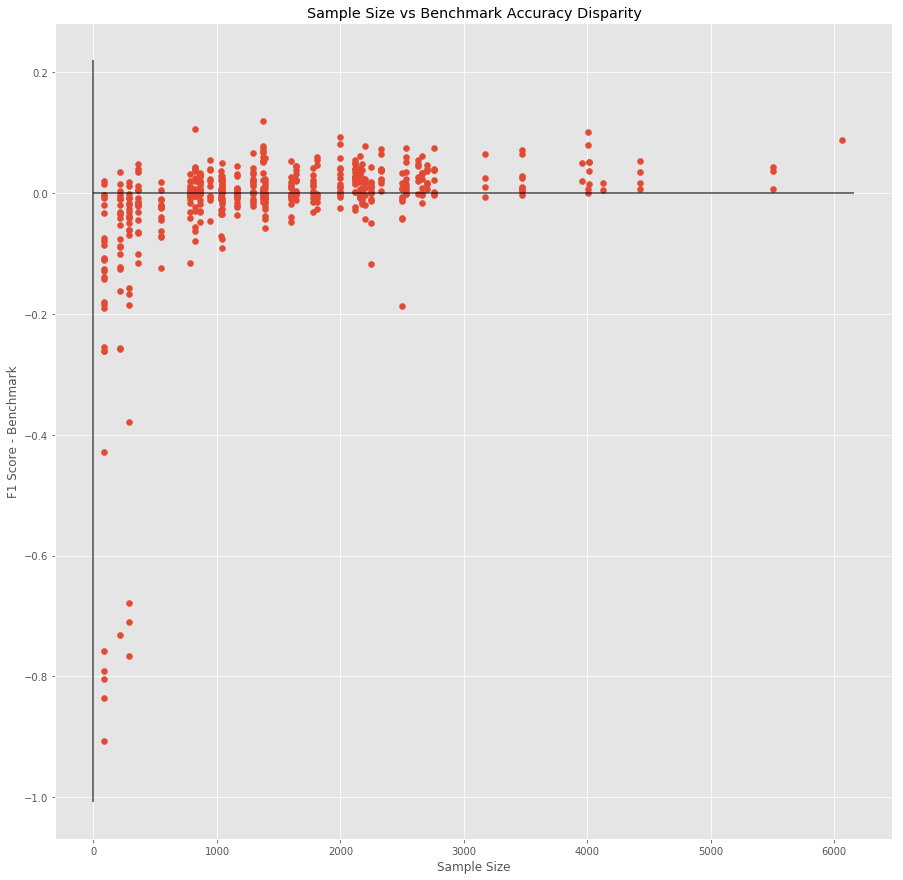

In [30]:
plt.figure(figsize=(15, 15))
plt.scatter(results_df['Sample Size'], results_df['Difference'])
plt.title('Sample Size vs Benchmark Accuracy Disparity')
plt.xlabel('Sample Size')
plt.ylabel('F1 Score - Benchmark')
plt.hlines(0, 0, results_df['Sample Size'].max()+100, colors='black', alpha=.7)
plt.vlines(0, results_df['Difference'].min()-.1, results_df['Difference'].max()+.1, colors='black', alpha=.7)
plt.show()

It appears neural networks tend to outperform traditional machine learning models when the sample size gets larger. This is to be expected as neural networks are known to work best when there is a lot of data. In addition, it can be seen that when the sample size is roughly less than 500, the variance in results is incredibly high. Going back to examples such as Garfield and Harrison, we can understand why: many these results are likely to be greater reflections of random chance with no practical application.

### Create Weighted Metrics
Rather than comparing the results by looking just at the scores for each sample, it would be worth looking at the results as they pertain to the total number of predictions. This can be accomplished bye creating a weighted benchmark and F1 score, which gives more significance to scores with higher sample sizes, and lower scores to those with smaller sample sizes. 

*Note: Another approach would be to simply drop results where the sample size is below a certain threshold, however we don't want to get rid of data yet. Simply reducing the significance of these results will allow us to err on the side of caution.*

In [31]:
n = np.sum(results_df['Sample Size'])
results_df['Weighted Benchmark'] = results_df['Benchmark'] * results_df['Sample Size'] / n
results_df['Weighted F1'] = results_df['Best F1 Score'] * results_df['Sample Size'] / n

weighted_bench_score = np.sum(results_df['Weighted Benchmark'])
weighted_F1_score = np.sum(results_df['Weighted F1'])
print(f'Weighted Benchmark Score:\t{weighted_bench_score}\nWeighted F1 Score:\t\t{weighted_F1_score}')

Weighted Benchmark Score:	0.8508295779426784
Weighted F1 Score:		0.8630366439556557


When creating weighted metrics, it can be observed that neural networks will work best with more data. 

#### General Accuracy Relative to Sample Size

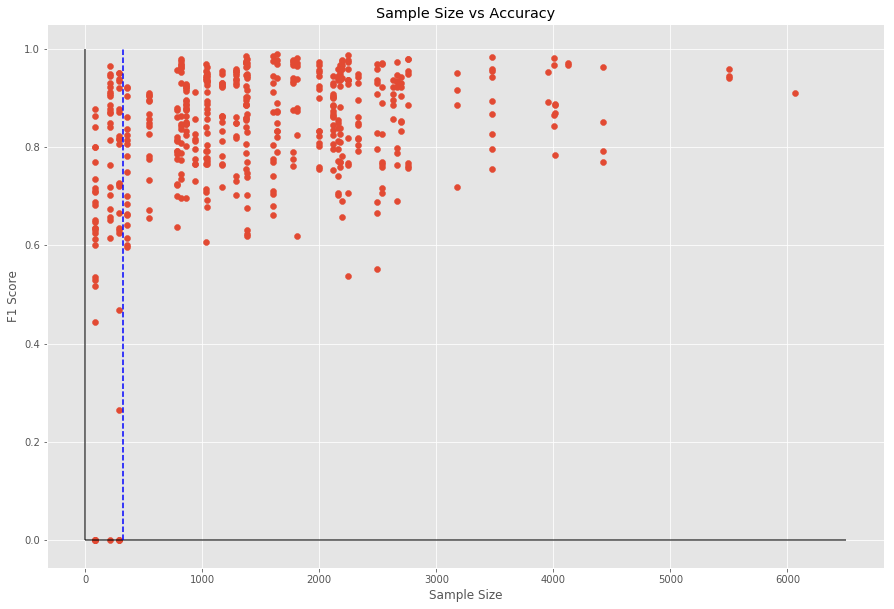

In [72]:
plt.figure(figsize=(15, 10))
plt.scatter(results_df['Sample Size'], results_df['Best F1 Score'])
plt.title('Sample Size vs Accuracy')
plt.xlabel('Sample Size')
plt.ylabel('F1 Score')
plt.hlines(0, 0, 6500, colors='black', alpha=.7)
plt.vlines(0, 0, 1, colors='black', alpha=.7)
plt.vlines(325, 0, 1, linestyles='--', colors='b')
plt.show()

An upward trend in accuracy, as well as a reduction in variance of results can be observed as sample size increases. It is likely that factoring other model factors will help account for some of the variance. However, a clear improvement in result variance can be observed around the 325 sample size mark.

### Results by Model Type
Three model types will be reviewed: CNN, RNN with GRU neurons, and RNN with LSTM neurons.

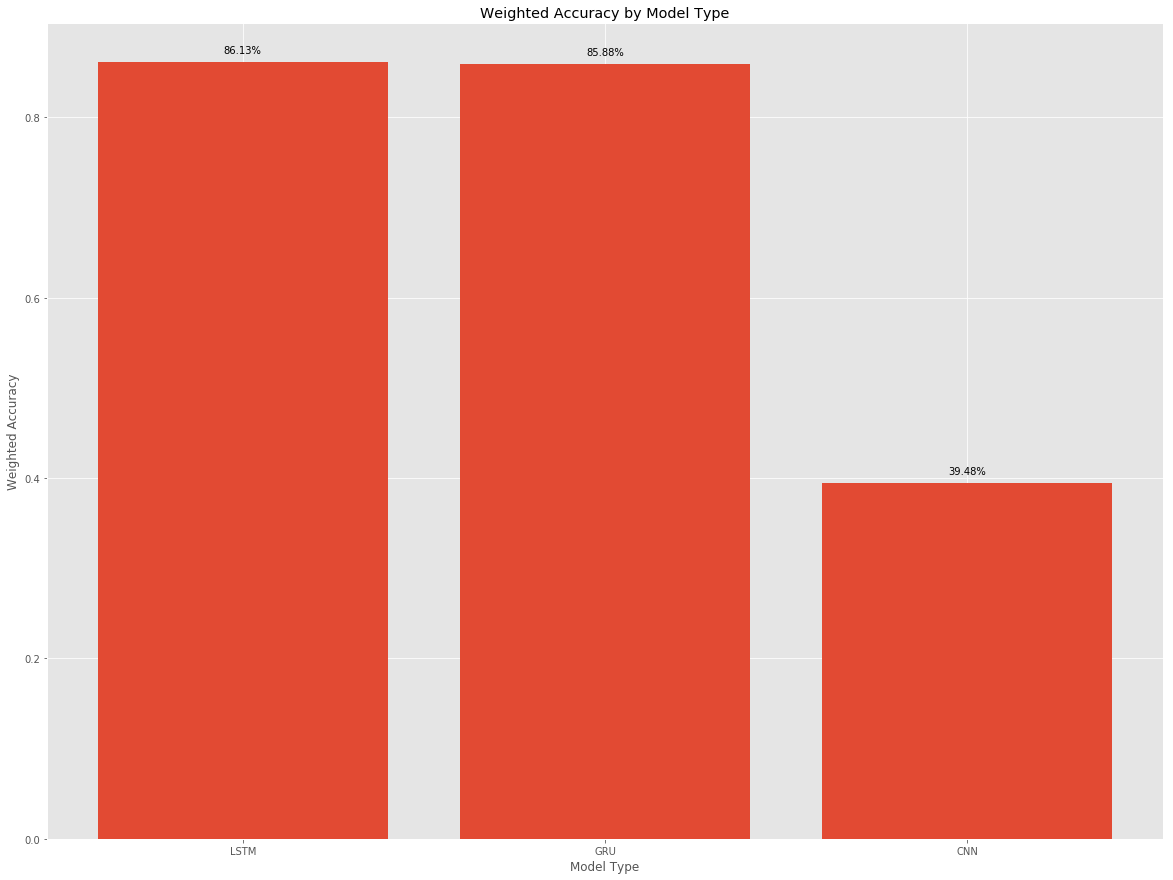

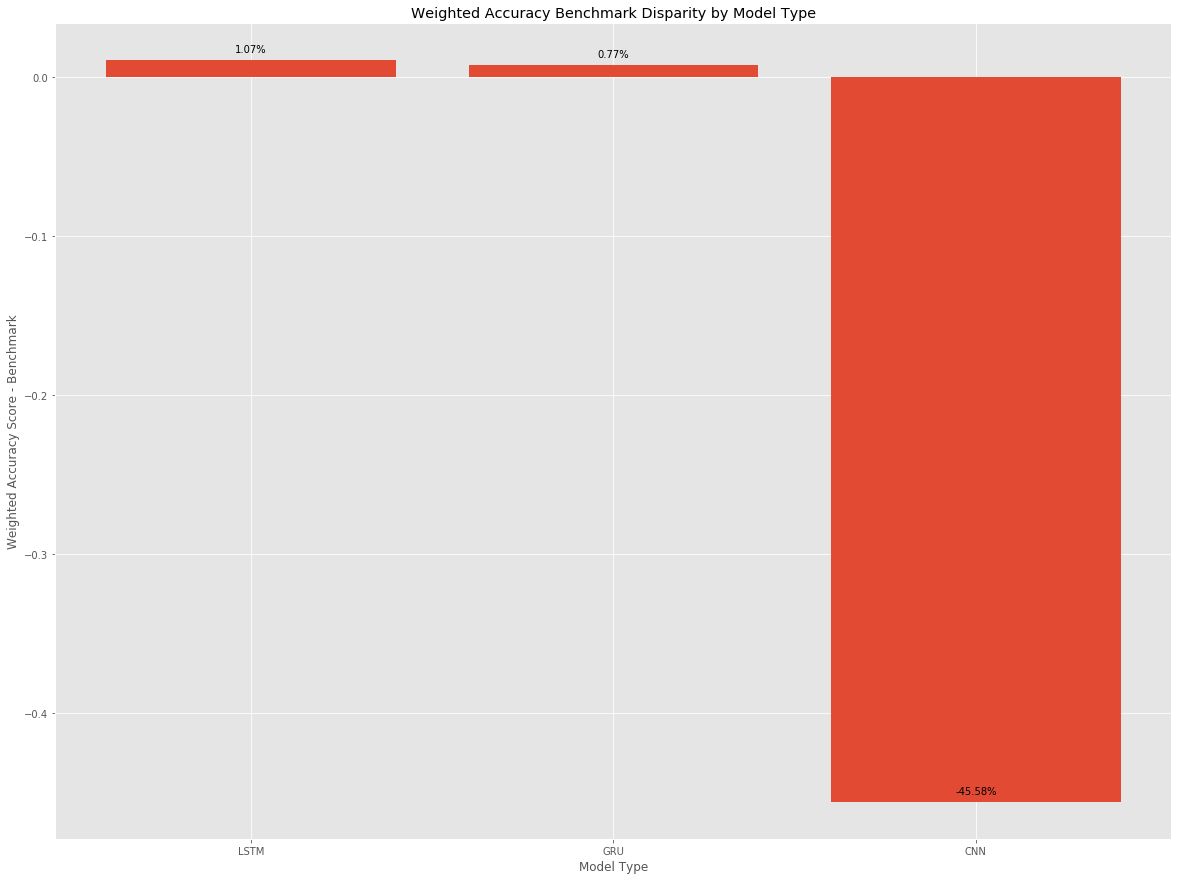

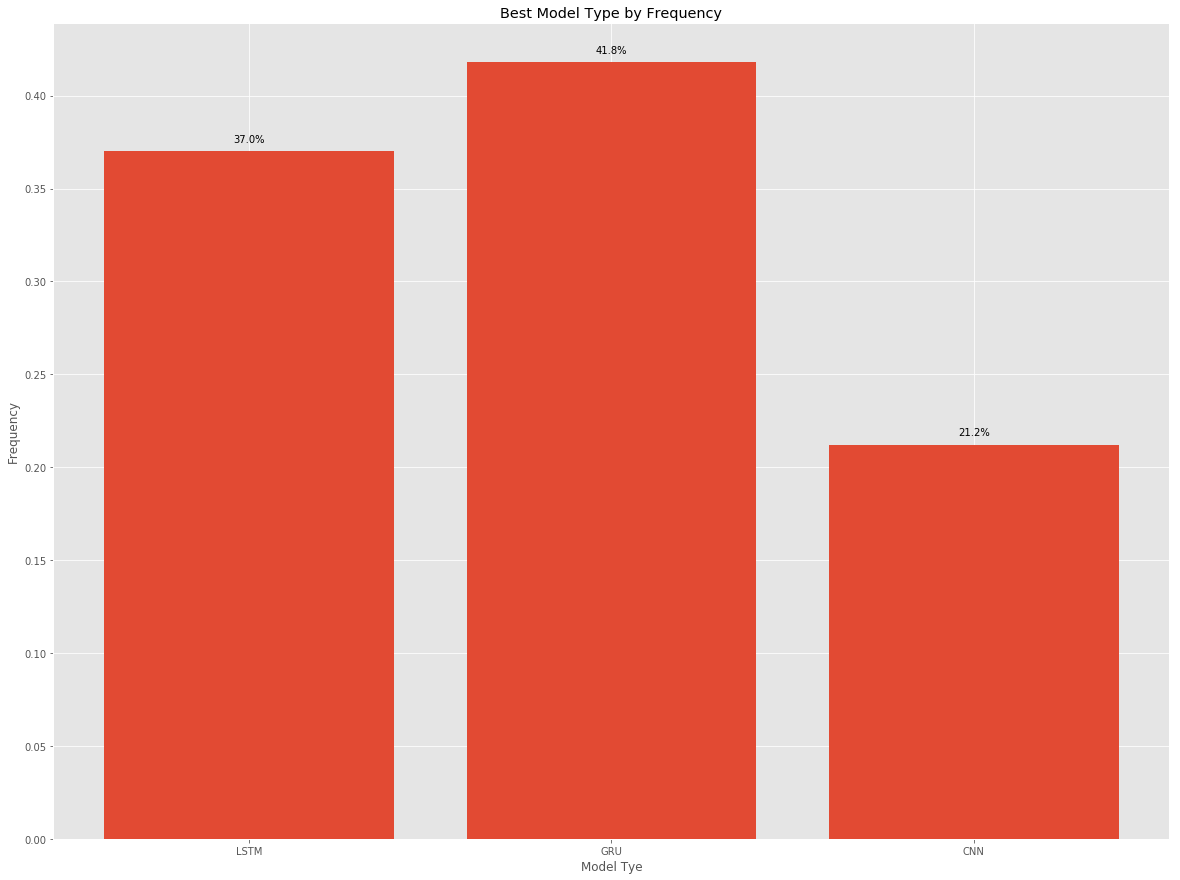

In [26]:
# Create dataframe for each model type
lstm_results = results_df[(results_df['RNN Type'] == 'lstm')]
gru_results = results_df[(results_df['RNN Type'] == 'gru')]
cnn_results = results_df

# Get LSTM Results
lstm_results['Weighted Bench'] = lstm_results['Benchmark'] * lstm_results['Sample Size'] / np.sum(lstm_results['Sample Size'])
lstm_results['Weighted Accuracy'] = lstm_results['RNN F1 Score'] * lstm_results['Sample Size'] / np.sum(lstm_results['Sample Size'])
lstm_acc = np.sum(lstm_results['Weighted Accuracy'])
lstm_bench = np.sum(lstm_results['Weighted Bench'])

# Get GRU Results
gru_results['Weighted Bench'] = gru_results['Benchmark'] * gru_results['Sample Size'] / np.sum(gru_results['Sample Size'])
gru_results['Weighted Accuracy'] = gru_results['RNN F1 Score'] * gru_results['Sample Size'] / np.sum(gru_results['Sample Size'])
gru_acc = np.sum(gru_results['Weighted Accuracy'])
gru_bench = np.sum(gru_results['Weighted Bench'])

# Get CNN Results
cnn_results['Weighted Bench'] = lstm_results['Benchmark'] * cnn_results['Sample Size'] / np.sum(lstm_results['Sample Size'])
cnn_results['Weighted Accuracy'] = lstm_results['CNN F1 Score'] * cnn_results['Sample Size'] / np.sum(cnn_results['Sample Size'])
cnn_acc = np.sum(cnn_results['Weighted Accuracy'])
cnn_bench = np.sum(cnn_results['Weighted Bench'])

# Set X, Y values for graphs
x = ['LSTM', 'GRU', 'CNN']
y1 = [lstm_acc, gru_acc, cnn_acc]
y2 = [lstm_acc - lstm_bench, gru_acc - gru_bench, cnn_acc - cnn_bench]

# Create graph of accuracy by model type
plt.figure(figsize = (20, 15))
plt.bar(x, y1)
for i in range(len(x)):
    plt.text(x[i], y1[i] + .01, f'{np.round(y1[i]*100, 2)}%', ha='center')
plt.xlabel('Model Type')
plt.ylabel('Weighted Accuracy')
plt.title('Weighted Accuracy by Model Type')
plt.show()

# Create graph of accuracy minus benchmark by model type
plt.figure(figsize = (20, 15))
plt.bar(x, y2)
for i in range(len(x)):
    plt.text(x[i], y2[i] + .005, f'{np.round(y2[i]*100, 2)}%', ha='center')
plt.xlabel('Model Type')
plt.ylabel('Weighted Accuracy Score - Benchmark')
plt.title('Weighted Accuracy Benchmark Disparity by Model Type')
plt.show()

# Show frequency with which model types are identified as best fit
lstm_count = lstm_results[lstm_results['Best Model Type']=='RNN'].shape[0]
gru_count = gru_results[gru_results['Best Model Type']=='RNN'].shape[0]
cnn_count = results_df[results_df['Best Model Type'] == 'CNN'].shape[0]

y = [lstm_count, gru_count, cnn_count]
y_norm = [i / np.sum(y) for i in y]

plt.figure(figsize = (20, 15))
plt.bar(x, y_norm)
for i in range(len(x)):
    plt.text(x[i], y_norm[i] + .005, f'{np.round(y_norm[i]*100, 2)}%', ha='center')
plt.xlabel('Model Tye')
plt.ylabel('Frequency')
plt.title('Best Model Type by Frequency')
plt.show()

We can see that RNN networks outperform traditional machine learning models (with LSTM neurons working slightly more effectively than GRU neurons), and they vastly outperform CNN models. However, in over 20% of cases, CNN's are still found to perform better than RNN's. This suggests that while RNN's are more generalizable, CNN's may perform better under more specific conditions.

## Conclusions and Next Steps
Clearly, it can be observed that this approach is on the right track to something. What that something is, is not quite clear yet. Performing regression analysis on the data, as well as identifying different features to the samples, can give a clearer picture of which models work best, given a set of conditions. For presidents A & B, can we predict which model structure is likely to yield the best results rather than having to implement a grid search each time? Can the process of building a neural network be optimized and automated, essentially building a machine to build machines?

This is obviously a whole other project on its own, but one I felt would be worth putting forward as a concept, demonstrating that data does seem to point to real possibilities in this regard. To take this a step further, a Bayesian approach may even allow for the incremental creation of network structure and architecture beyond simple tuning of hyperparameters. If such a task can be accomplished, there is no reason to think a neural network couldn't be built on the fly to compare any two individuals based on public text data.

## A Final Word Cloud
In addition to the results, bigram data has been saved for errors under specific conditions. The hope was that certain words could be captured throughout the ages that reflect some of the most common themes in American politics: the good, the bad, and the ugly. Find below a word cloud made up the 500 most common words in this corpus.

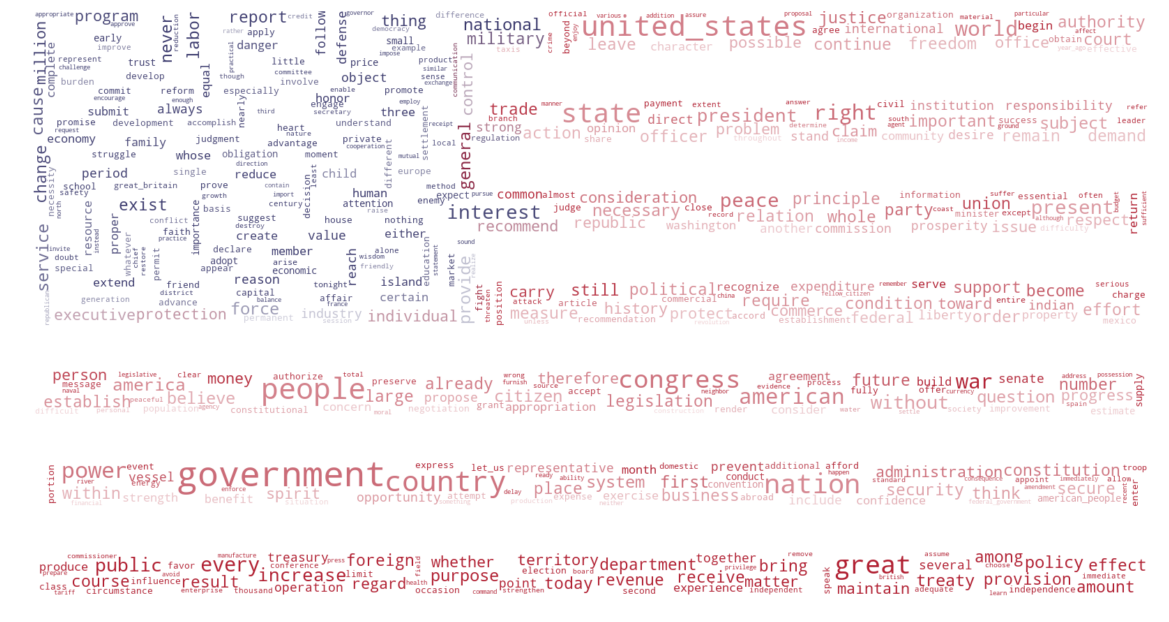

In [67]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import Image as im
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

colors = ["#FF0000", "#FF6347", "#DC143C", "#0000FF", "#0000CD", "#4169E1"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

# Create error wordcloud
error_mask = np.array(Image.open('american_flag.png'))
error_wc = WordCloud(background_color="white", mode="RGBA",
                     mask=error_mask, max_words=500)
error_wc.generate(error_cloud)

# Display word cloud
image_colors = ImageColorGenerator(error_mask)

plt.figure(figsize=(20, 35))
plt.imshow(error_wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.show()